In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import numpy as np
import seaborn as sns

C:\Users\sunwh\Downloads\Anaconda\download\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# craft maps
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import shapely
from shapely.geometry import Point, Polygon

In [3]:
# handle missing values/ outliers
import statistics
from statistics import median
import astropy.stats 
from astropy.stats import median_absolute_deviation
from sklearn.impute import KNNImputer

# airbnb data clean

In [4]:
# read in data
# airbnb_org = pd.read_csv("airbnb.csv")

C:\Users\sunwh\Downloads\Anaconda\download\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (43,61,62,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# take a look at the original dataset
airbnb_org.shape

(48895, 106)

In [6]:
airbnb_org.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2539,https://www.airbnb.com/rooms/2539,20190708031610,2019-07-09,Clean & quiet apt home by the park,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,...,f,f,moderate,f,f,6,0,5,1,0.21
1,2595,https://www.airbnb.com/rooms/2595,20190708031610,2019-07-09,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,...,f,f,strict_14_with_grace_period,t,t,2,1,0,1,0.38
2,3647,https://www.airbnb.com/rooms/3647,20190708031610,2019-07-08,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,...,f,f,strict_14_with_grace_period,t,t,1,0,1,0,NaN
3,3831,https://www.airbnb.com/rooms/3831,20190708031610,2019-07-09,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,f,f,moderate,f,f,1,1,0,0,4.64
4,5022,https://www.airbnb.com/rooms/5022,20190708031610,2019-07-08,Entire Apt: Spacious Studio/Loft by central park,NaN,Loft apartment with high ceiling and wood floo...,Loft apartment with high ceiling and wood floo...,none,NaN,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.10


In [94]:
# select columns that MAY be used for analysis and save them in a new dataframe
airbnb = airbnb_org[['city',
                  'state',
                  'zipcode',
                  'bedrooms',
                  'price',
                  'weekly_price',
                  'monthly_price',
                  'latitude',
                  'longitude',
                  'is_location_exact',
                  'neighbourhood_group_cleansed',
                  'room_type',
                  'property_type',
                  'cleaning_fee']]

In [95]:
# rename column names to make them more readable
airbnb.rename(columns={'price':'nightly_price','neighbourhood_group_cleansed':'Borough'},inplace=True)

C:\Users\sunwh\Downloads\Anaconda\download\lib\site-packages\pandas\core\frame.py:4130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Check duplicates

In [96]:
# check duplicates
airbnb.duplicated().sum()

0

# Filtering 2 bedrooms properties

In [97]:
# check the datatype of yhe 'bedrooms' col
airbnb.bedrooms.dtype

# check missing values of the 'bedrooms' col
airbnb.bedrooms.isnull().sum()

# remove missing values of the 'bedrooms' col 
airbnb = airbnb.dropna(subset=['bedrooms'])

# convert the 'bedrooms' col from float into int
airbnb['bedrooms'] = airbnb['bedrooms'].apply(np.int64)

# filtering properties that have two bedrooms and save the data into a new dataframe
airbnb_2bed = airbnb[airbnb['bedrooms'] == 2]

In [98]:
# filtering data whose location is not accurate 
airbnb_2bed = airbnb_2bed[airbnb_2bed['is_location_exact'] =='t']

# Check missing values

In [99]:
# check missing values of the rest cols
# calculate the sum and percentage of missing values
# sum
airbnb_2bed.isnull().sum()

city                    5
state                   1
zipcode                 1
bedrooms                0
nightly_price           0
weekly_price         4819
monthly_price        4914
latitude                0
longitude               0
is_location_exact       0
Borough                 0
room_type               0
property_type           0
cleaning_fee          801
dtype: int64

In [100]:
# percentage
100*airbnb_2bed.isnull().mean()

city                  0.090025
state                 0.018005
zipcode               0.018005
bedrooms              0.000000
nightly_price         0.000000
weekly_price         86.766295
monthly_price        88.476773
latitude              0.000000
longitude             0.000000
is_location_exact     0.000000
Borough               0.000000
room_type             0.000000
property_type         0.000000
cleaning_fee         14.422038
dtype: float64

In [101]:
# city, state, zipcode, weekly_price, monthly_price and cleaning_fee have missing values
# determine whether to impute/delete the rows or even the entire column based on the percentage of the 
# missing values and the relative importance of the variable towards the analysis

In [102]:
# missing 'weekly_price' & 'monthly_price'
# I was planning to use 'weekly_price' and 'monthly_price' to get more accurate result, but since the percentage of missing values 
# is too high, I am not going to use this two cols

# drop weekly_price & monthly_price cols
airbnb_2bed = airbnb_2bed.drop(['weekly_price','monthly_price'],axis=1)
airbnb_2bed.head()

,city,state,zipcode,bedrooms,nightly_price,latitude,longitude,is_location_exact,Borough,room_type,property_type,cleaning_fee
19,New York,NY,10029,2,$190.00,40.79685,-73.94872,t,Manhattan,Entire home/apt,Apartment,NaN
48,Brooklyn,NY,11221,2,$115.00,40.68554,-73.94090,t,Brooklyn,Entire home/apt,Townhouse,$85.00
52,Brooklyn,NY,11206,2,$228.00,40.70420,-73.93560,t,Brooklyn,Entire home/apt,Loft,$128.00
61,New York,NY,10001,2,$375.00,40.74623,-73.99530,t,Manhattan,Entire home/apt,Apartment,$120.00
62,New York,NY,10162,2,$250.00,40.77065,-73.95269,t,Manhattan,Entire home/apt,Apartment,$200.00


In [103]:
# missing 'zipcode' 
# only one missing zipcode, thus we can just search the zipcode by lat and lon from google
airbnb_2bed[airbnb_2bed['zipcode'].isnull()]

,city,state,zipcode,bedrooms,nightly_price,latitude,longitude,is_location_exact,Borough,room_type,property_type,cleaning_fee
3013,New York,NY,NaN,2,$275.00,40.74849,-73.94947,t,Queens,Entire home/apt,Apartment,$100.00


In [104]:
airbnb_2bed.zipcode.fillna('10019', inplace=True)

In [105]:
# missing 'cleaning_fee'
# since the missing percent of cleaning_fee is not too high, I choose to impute the missing values instead of deleting them
# check the data type and format before imputing

In [106]:
# split dataframe into two part based on the null values of 'cleaning_fee'
cf_notnull = airbnb_2bed[airbnb_2bed['cleaning_fee'].notnull()]
cf_isnull = airbnb_2bed[airbnb_2bed['cleaning_fee'].isnull()]

In [107]:
# check datatype and format of cf_notnull
# cf_notnull.cleaning_fee.unique()

In [108]:
# correct the datatype and format
cf_notnull['cleaning_fee']=cf_notnull['cleaning_fee'].str.replace("[$,,]","") 
cf_notnull['cleaning_fee']=pd.to_numeric(cf_notnull['cleaning_fee'],downcast='float')
cf_notnull.cleaning_fee.unique()

C:\Users\sunwh\Downloads\Anaconda\download\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\sunwh\Downloads\Anaconda\download\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 85., 128., 120., 200.,  30.,  79., 100., 250.,  65.,  75.,   0.,
        60., 125., 150., 165.,  80.,  70.,  45.,  50., 115.,  40., 149.,
       110.,  90.,  95.,  99., 145., 130.,  14.,  25., 135., 160., 175.,
       195., 180.,  69.,  20., 350.,  55.,  35.,  61.,  10., 190.,  15.,
        98., 140., 199.,  59., 240.,  88.,  89., 185., 295., 225., 139.,
        92., 300.,  82., 430., 159., 155., 121.,  67., 105.,  49.,  52.,
        48., 600., 129.,  81., 109.,  97.,  68.,   5.,  12., 275.,  62.,
       108., 179., 119.,  29.,   8.,  63.,  34.,  84.,  66.,  13.,  71.,
       260., 400.,  19.,  26.,  39.,  47., 340.,  18., 215., 230., 168.,
        57., 118., 299., 147.,  87.,  38., 482.,  42., 111., 196., 134.,
       500.], dtype=float32)

In [109]:
# filter out negative and zero values  -- host can choose not to charge cleaning_fee, thus zeros should
# also be taken into account
cf_notnull = cf_notnull[cf_notnull.cleaning_fee > 0]

In [110]:
# merge the split dataframes together
airbnb_2bed = pd.concat([cf_notnull,cf_isnull],axis=0)

In [111]:
airbnb_2bed['cleaning_fee']=airbnb_2bed['cleaning_fee'].astype('float')

# impute missing cleaning_fee with KNN

In [112]:
airbnb_2bed_dm = airbnb_2bed[['room_type','property_type','Borough']]
airbnb_2bed_dm = pd.get_dummies(airbnb_2bed_dm)
airbnb_2bed_dm['cleaning_fee'] = airbnb_2bed['cleaning_fee']

airbnb_2bed_arr=airbnb_2bed_dm.values
imputer = KNNImputer(n_neighbors=2) 
airbnb_2bed_arr=imputer.fit_transform(airbnb_2bed_arr)
airbnb_2bed_im=pd.DataFrame(airbnb_2bed_arr, columns=airbnb_2bed_dm.columns)

airbnb_2bed['cleaning_fee'] = airbnb_2bed_im['cleaning_fee'].values

# Detect property location

In [113]:
# this step is used to determine whether remove rows that have missing values on city/state level

In [114]:
# create a geodataframe for airbnb datset
bnb_geometry = [Point(xy) for xy in zip(airbnb_2bed['longitude'],airbnb_2bed['latitude'])]
crs = {"init": "epsg:4326"}
geo_airbnb = gpd.GeoDataFrame(airbnb_2bed,crs=crs,geometry=bnb_geometry)

''

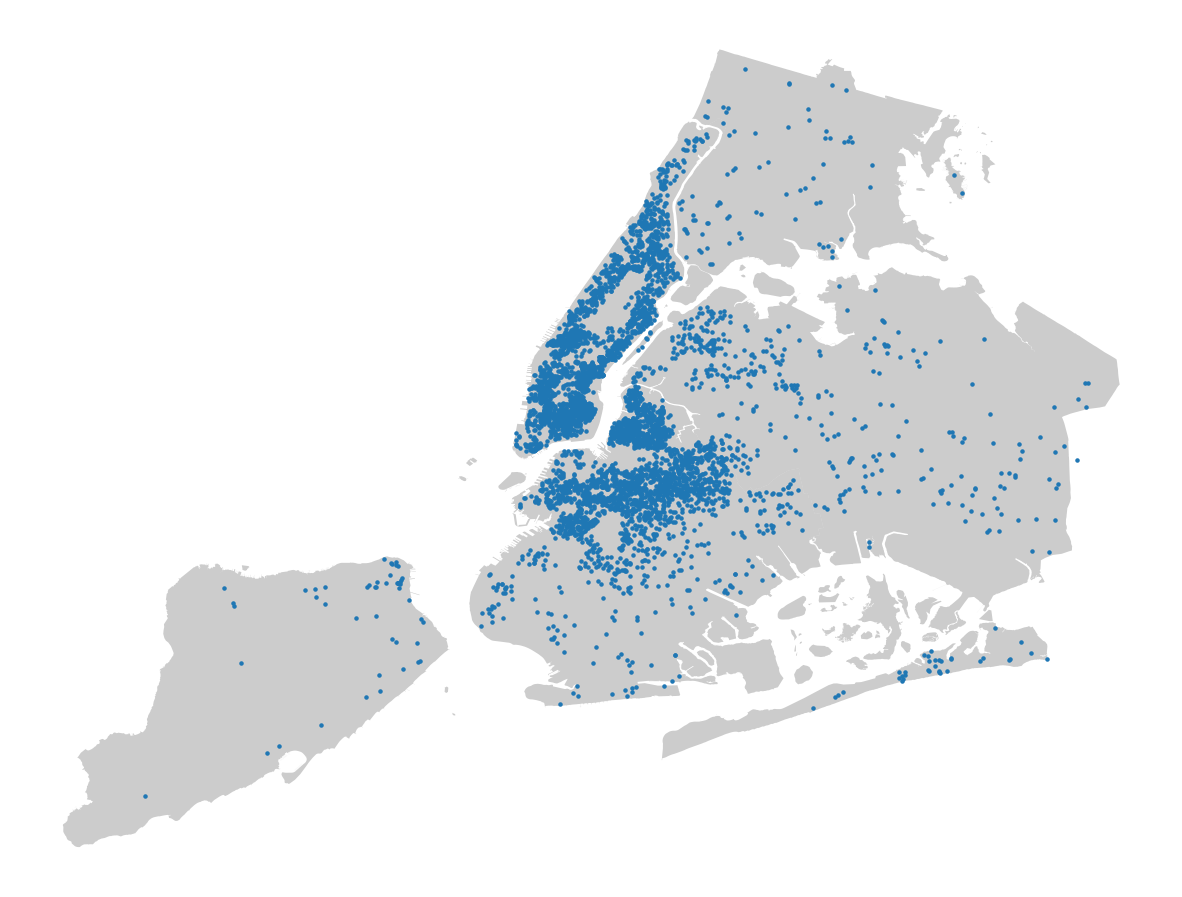

In [115]:
# visualize the location of every property(each data point) on the base map
map = gpd.read_file(gpd.datasets.get_path("nybb"))
map = map.to_crs({"init": "epsg:4326"})
plt.style.use('default')
fig,ax = plt.subplots(figsize=(15,12))
map.plot(ax=ax,alpha=0.4,color="gray")
geo_airbnb.plot(ax=ax,marker="o",markersize=5)
ax.axis('off')
;
# plt.savefig('distribution.png')

In [116]:
# From the plot above we can see, just one or two points are not in NYC
# Now I write a 'for loop' to automatically detect points outside of NYC
# reference link for the detection loop: https://stackoverflow.com/questions/48097742/geopandas-point-in-polygon 

# detect property not in NYC
bnb_geometry_=gpd.GeoDataFrame(geometry=bnb_geometry)
bnb_geometry_=bnb_geometry_.assign(**{str(key): bnb_geometry_.within(geom) for key, geom in map.geometry.items()})

# bnb_geometry_

idx_outside=[]
for k in bnb_geometry_.index:
    if np.sum(bnb_geometry_.iloc[k,1:].values) == False:
        idx_outside.append(k)

In [117]:
# get index of point(s) outside of NYC
idx_outside

[4034]

In [118]:
type(idx_outside)

list

In [119]:
# remove data point(s) outside of NYC
for idx in idx_outside:
    airbnb_2bed.drop(airbnb_2bed.index[idx],inplace=True)

In [120]:
# Based on the result of the location detection
# simply assign NYC to missing city values and NY to missing state values
airbnb_2bed['city'] = airbnb_2bed.city.replace(np.nan,'NYC')
airbnb_2bed['state'] = airbnb_2bed.city.replace(np.nan,'NY')

In [121]:
# check missing values of the whole dataframe again
airbnb_2bed.isnull().sum()

city                 0
state                0
zipcode              0
bedrooms             0
nightly_price        0
latitude             0
longitude            0
is_location_exact    0
Borough              0
room_type            0
property_type        0
cleaning_fee         0
geometry             0
dtype: int64

# Check data types and data format

In [122]:
# check datatypes of the rest columns(except bedrooms,cleaning_fee)
airbnb_2bed.dtypes

city                   object
state                  object
zipcode                object
bedrooms                int64
nightly_price          object
latitude              float64
longitude             float64
is_location_exact      object
Borough                object
room_type              object
property_type          object
cleaning_fee          float64
geometry             geometry
dtype: object

In [123]:
# check data format
for col in list(airbnb_2bed):
    print (col.capitalize(),airbnb_2bed[col].unique(), sep="\n")
    print()

City
['Brooklyn' 'New York' 'Queens' 'Long Island City' 'Riverdale ' 'Bronx'
 'Staten Island' 'Brooklyn ' 'Astoria' 'Jamaica' 'LONG ISLAND CITY'
 'Fort Greene, Brooklyn' 'Park Slope, Brooklyn' 'Saint Albans(Queens)'
 'EAST ELMHURST' 'jackson heights' 'Woodside' 'NYC' 'Brooklyn, New York'
 'Forest Hills' 'RIVERDALE' 'astoria' 'Long Island city' 'MIDDLE VILLAGE'
 'Jackson Heights' 'Rockaway Beach' 'Howard Beach' 'Lawrence' 'The Bronx'
 'New York City' 'Manhattan ' 'Manhattan' 'ASTORIA' 'NY' 'Astoria '
 'Chelsea, New York' 'Jackson Heights ' 'Woodside ']

State
['Brooklyn' 'New York' 'Queens' 'Long Island City' 'Riverdale ' 'Bronx'
 'Staten Island' 'Brooklyn ' 'Astoria' 'Jamaica' 'LONG ISLAND CITY'
 'Fort Greene, Brooklyn' 'Park Slope, Brooklyn' 'Saint Albans(Queens)'
 'EAST ELMHURST' 'jackson heights' 'Woodside' 'NYC' 'Brooklyn, New York'
 'Forest Hills' 'RIVERDALE' 'astoria' 'Long Island city' 'MIDDLE VILLAGE'
 'Jackson Heights' 'Rockaway Beach' 'Howard Beach' 'Lawrence' 'The Bronx'
 'N

In [124]:
# uniform city & state names based on the result of location detection 
airbnb_2bed['city'] = 'NYC'
airbnb_2bed['state'] = 'NY'

In [125]:
# removing '$' sign and commas from 'nightly_price'
airbnb_2bed['nightly_price']=airbnb_2bed['nightly_price'].str.replace("[$,,]","")  

In [126]:
# convert price to numeric 
airbnb_2bed['nightly_price']= pd.to_numeric(airbnb_2bed['nightly_price'],downcast='float')

In [127]:
# filter out negative and zero values for nightly_price
airbnb_2bed = airbnb_2bed[airbnb_2bed['nightly_price'] > 0]

In [128]:
# correct the format of 'zipcode'
airbnb_2bed['zipcode'] = airbnb_2bed.zipcode.astype(int)
airbnb_2bed['zipcode'] = airbnb_2bed.zipcode.astype(object)

# Handling outliers

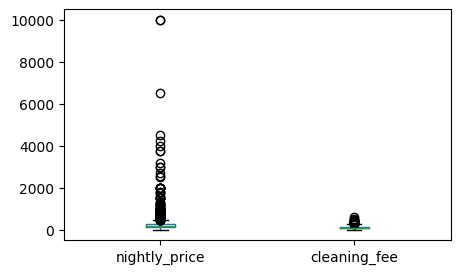

In [42]:
# take a look at the distribution od data by boxplot and histagram
plt.style.use('default')

boxplot = airbnb_2bed.boxplot(column=['nightly_price','cleaning_fee'],grid=False,figsize=(5,3))
# plt.savefig('boxplot1.png')

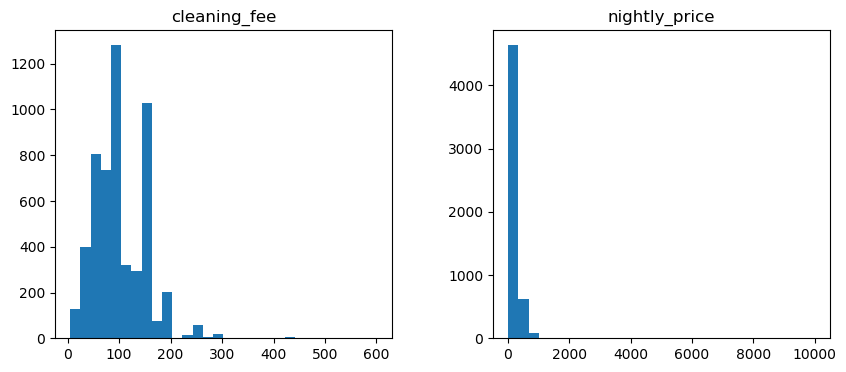

In [43]:
plt.style.use('default')
airbnb_2bed.hist(['cleaning_fee', 'nightly_price'], figsize=(10,4), bins=30,grid=False);
# plt.savefig('histagrams1.png')

In [44]:
# filter out outliers for nightly_price
med_dp = median(airbnb_2bed['nightly_price'])
mad_dp = median_absolute_deviation(airbnb_2bed['nightly_price'])
threshold_dp = med_dp+3*mad_dp  # calculate outlier cut-off
airbnb_2bed = airbnb_2bed[airbnb_2bed['nightly_price'] < threshold_dp]

In [45]:
# filter out outliers for cleaning_fee
med_cf = median(airbnb_2bed['cleaning_fee'])
mad_cf = median_absolute_deviation(airbnb_2bed['cleaning_fee'])
threshold_cf = med_cf+3*mad_cf  # calculate outlier cut-off
airbnb_2bed = airbnb_2bed[airbnb_2bed['cleaning_fee'] < threshold_cf]

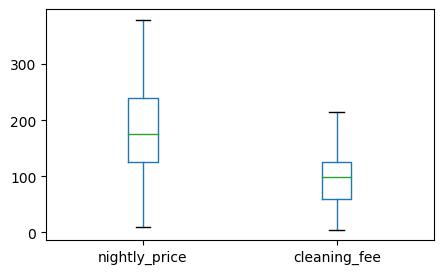

In [46]:
# check the distribution of data after filtering out the outliers
plt.style.use('default')
boxplot = airbnb_2bed.boxplot(column=['nightly_price','cleaning_fee'],grid=False,figsize=(5,3))
# plt.savefig('boxplot2.png')

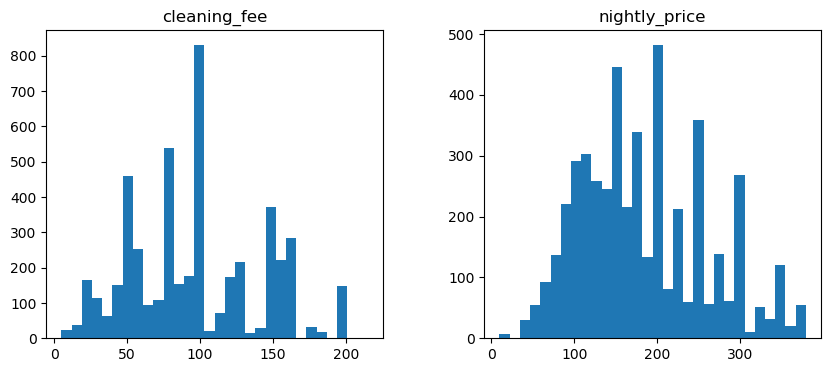

In [47]:
plt.style.use('default')
airbnb_2bed.hist(['cleaning_fee', 'nightly_price'], figsize=(10,4),bins=30,grid=False);
# plt.savefig('histgrams2.png')

In [48]:
# double the nightly_price if the room type is not 'entire home/apt'
airbnb_2bed.nightly_price.unique()
airbnb_2bed.loc[airbnb_2bed['room_type'] != 'Entire home/apt','nightly_price'] = airbnb_2bed['nightly_price']*2

In [49]:
airbnb_2bed.head()

,city,state,zipcode,bedrooms,nightly_price,latitude,longitude,is_location_exact,Borough,room_type,property_type,cleaning_fee,geometry
48,NYC,NY,11221,2,115.0,40.68554,-73.94090,t,Brooklyn,Entire home/apt,Townhouse,85.0,POINT (-73.94090 40.68554)
52,NYC,NY,11206,2,228.0,40.70420,-73.93560,t,Brooklyn,Entire home/apt,Loft,128.0,POINT (-73.93560 40.70420)
61,NYC,NY,10001,2,375.0,40.74623,-73.99530,t,Manhattan,Entire home/apt,Apartment,120.0,POINT (-73.99530 40.74623)
62,NYC,NY,10162,2,250.0,40.77065,-73.95269,t,Manhattan,Entire home/apt,Apartment,200.0,POINT (-73.95269 40.77065)
76,NYC,NY,10075,2,400.0,40.76865,-73.95058,t,Manhattan,Private room,Apartment,30.0,POINT (-73.95058 40.76865)


# Convert to zipcode level

In [50]:
# generate a new dataframe by zipcode level
grouped = airbnb_2bed.groupby(by='zipcode')[['nightly_price','cleaning_fee']].median()

In [51]:
grouped.head()

,nightly_price,cleaning_fee
zipcode,,
10001,260.0,100.0
10002,225.0,100.0
10003,227.5,99.5
10004,270.0,130.0
10005,255.0,110.0


In [52]:
arr = np.array(grouped.index)
series = pd.Series(arr)

In [53]:
type(series)

pandas.core.series.Series

In [54]:
grouped['zipcode'] = series.values

In [55]:
grouped.index.names = [' '] # change the index-level name

In [56]:
# df.drop_duplicates('Zone',keep='first')
zip_unique=airbnb_2bed.drop_duplicates('zipcode',keep='first')

In [57]:
zip_unique = zip_unique[['zipcode','Borough']]

In [58]:
zip_unique = zip_unique.sort_values(by=['zipcode'])

In [59]:
grouped['Borough'] = zip_unique['Borough'].values

In [60]:
airbnb_2bed_zip = grouped

In [61]:
# change the order of columns
airbnb_2bed_zip = airbnb_2bed_zip[['zipcode','Borough','nightly_price','cleaning_fee']]

In [62]:
airbnb_2bed_zip.head(10)

,zipcode,Borough,nightly_price,cleaning_fee
,,,,
10001,10001,Manhattan,260.0,100.0
10002,10002,Manhattan,225.0,100.0
10003,10003,Manhattan,227.5,99.5
10004,10004,Manhattan,270.0,130.0
10005,10005,Manhattan,255.0,110.0
10006,10006,Manhattan,225.0,150.0
10009,10009,Manhattan,247.0,100.0
10010,10010,Manhattan,255.0,100.0
10011,10011,Manhattan,250.0,100.0


# Clean Zillow dataset

In [63]:
# read in zillow dataset
# zillow_org = pd.read_csv("zillow.csv")

# take a look at the original dataset
zillow_org.shape

zillow_org.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,61639,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,...,1374400,1364100,1366300,1354800.0,1327500,1317300,1333700,1352100,1390000,1431000
1,84654,60657,Chicago,IL,Chicago,Cook,2,167700.0,166400.0,166700.0,...,368600,370200,372300,375300.0,378700,381400,381800,382100,383300,385100
2,61637,10023,New York,NY,New York,New York,3,NaN,NaN,NaN,...,1993500,1980700,1960900,1951300.0,1937800,1929800,1955000,2022400,2095000,2142300
3,84616,60614,Chicago,IL,Chicago,Cook,4,195800.0,193500.0,192600.0,...,398900,401200,403200,405700.0,408300,408800,408000,410100,412200,412200
4,93144,79936,El Paso,TX,El Paso,El Paso,5,59100.0,60500.0,60900.0,...,82400,82300,82400,82300.0,82500,83200,83900,84100,83900,83700


In [64]:
# duplicate the original dataset and make all the modifications on the duplicated dataset
zillow = zillow_org

# drop object-columns that I won't use
zillow = zillow.drop(['RegionID','Metro','CountyName','SizeRank'],axis=1)

# rename column name to make it more readable
zillow.rename(columns={'RegionName':'zipcode'},inplace=True)

zillow.head()

# check duplicates
zillow.duplicated().sum()

# take a look at the City & State columns -- check the consistency of name format
zillow.City.unique()
zillow.State.unique()

# filter out data that are not in New York City
zillow = zillow[(zillow['City']=='New York') & (zillow['State']=='NY')]

Zipcode
[10025 10023 10128 10011 10003 11201 11234 10314 11215 10028 10021 10014
 10036 11434 10306 10312 10022 11217 10013 11231 10304 10305 10309 10308
 10303]

City
['New York']

State
['NY']

2010-01
[ 813300. 1271900.  985400. 1378600. 1227800.  742800.  378700.  288700.
  529300. 1126000. 1163900. 1451800. 1238600.  315400.  297200.  296200.
 1323000.  619000. 2268700.  591300.  266200.  331100.  320000.  323400.
  267300.]

2010-02
[ 821500. 1252300.  983700. 1372300. 1202600.  747500.  386600.  290800.
  544800. 1107300. 1176400. 1454400. 1227700.  320300.  296500.  296400.
 1338500.  619300. 2294100.  589600.  266100.  330000.  320000.  324900.
  269300.]

2010-03
[ 831700. 1262300.  983400. 1393100. 1207100.  750300.  391600.  290200.
  540900. 1116100. 1184500. 1494500. 1230700.  315800.  296100.  296900.
 1344600.  612700. 2273600.  589500.  264700.  328100.  317400.  325000.
  265700.]

2010-04
[ 845100. 1279200. 1007600. 1430000. 1220100.  753800.  392900.  289200.
  5383

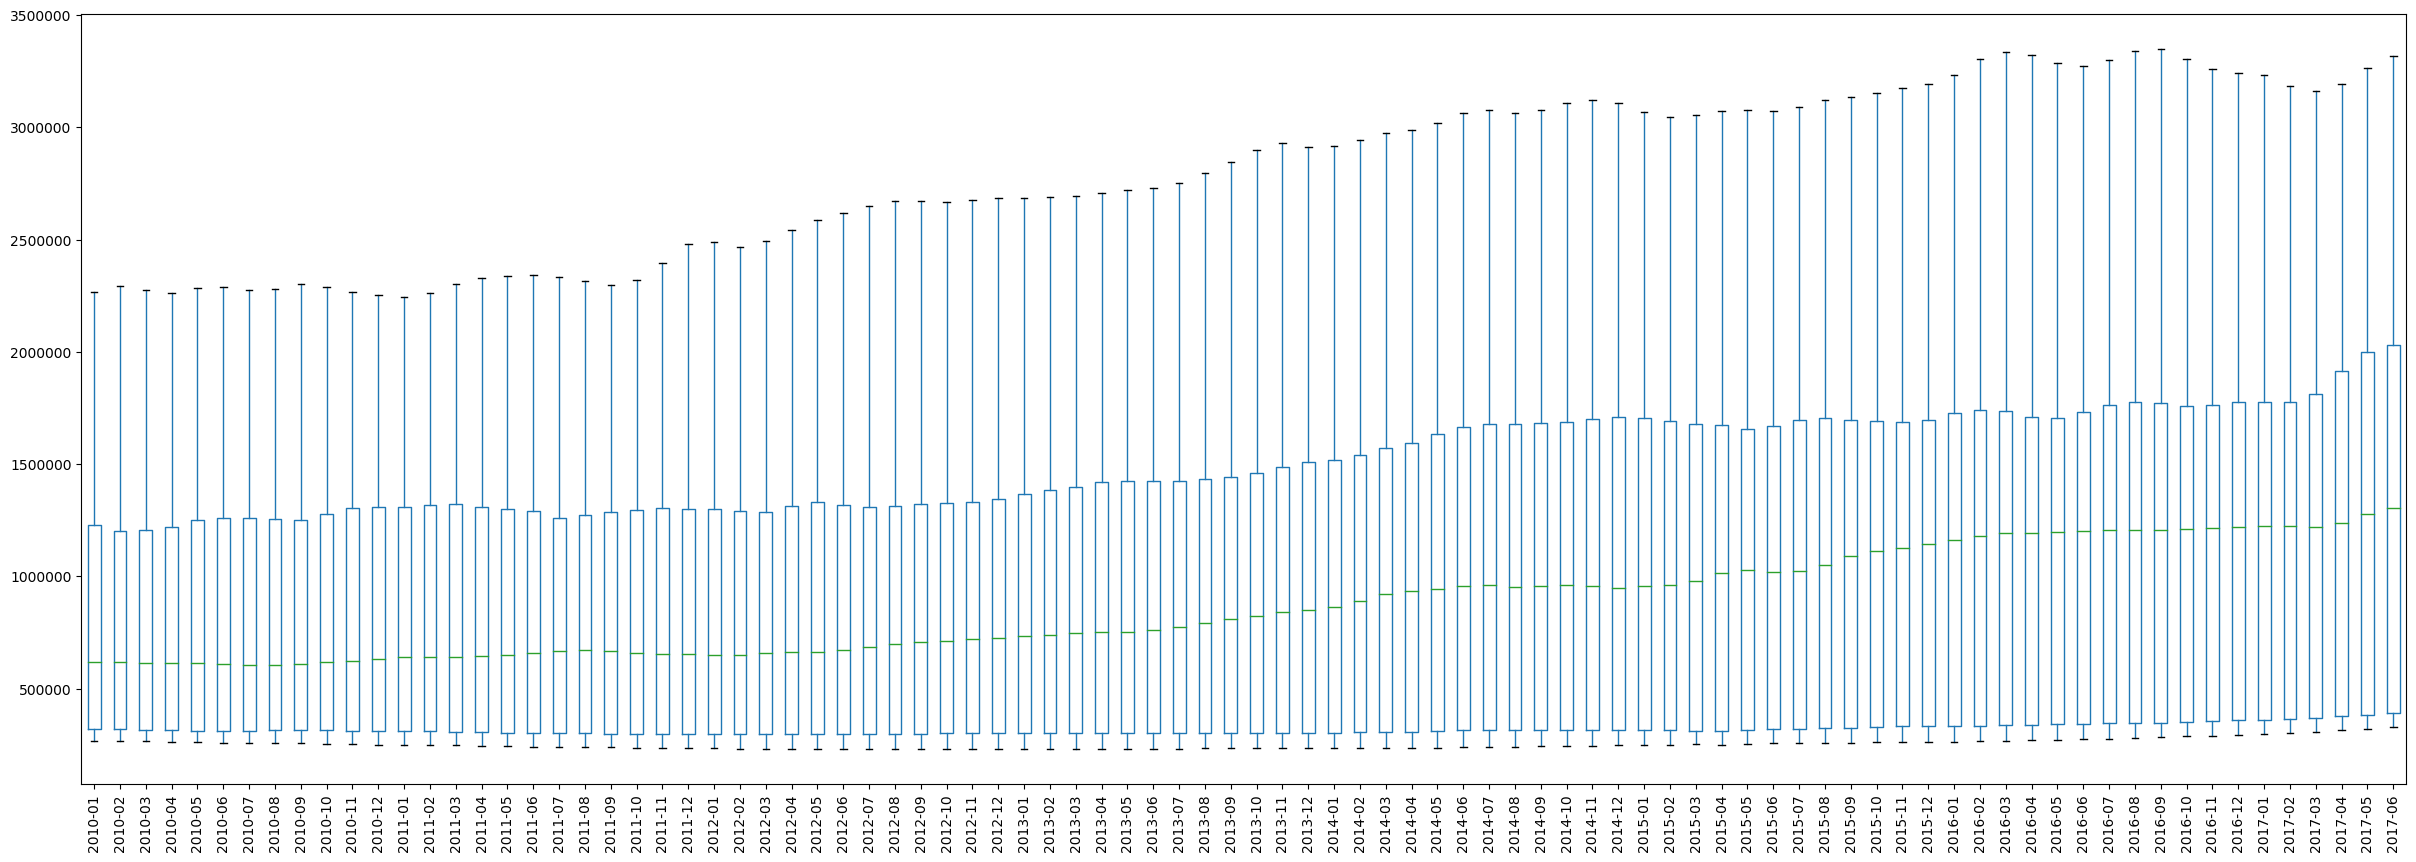

In [65]:
# select time period - the latest year [2016-06~2017-06]
select_cols1 = zillow.loc[:,"2010-01":"2017-06"]
select_cols2 = zillow.loc[:,("zipcode","City","State")]
zillow = pd.concat([select_cols2,select_cols1],axis=1)
zillow.head()

# calculate the percentage of missing values of each column
100*zillow.isnull().mean()

# check the datatype of each column
zillow.dtypes

# convert the zipcode from numeric col to object col
zillow['zipcode'] = zillow.zipcode.astype(object)

# check the format of each column
for col in list(zillow):
    print (col.capitalize(),zillow[col].unique(), sep="\n")
    print()

# check outliers
col_list = list(zillow.loc[:,"2010-01":"2017-06"])
boxplot = zillow.boxplot(column=col_list,grid=False,rot=90,figsize=(30,10)) 

# calculate the median price on yearly level
# 2010-2016
start=3
stop=start+12
# names = ['medp2010','medp2011','medp2012','medp2013','medp2014','medp2015','medp2016']
names = ['2010','2011','2012','2013','2014','2015','2016']
for i in range(0,7):
    col_list = list(zillow.iloc[:,start:stop])

    zillow[names[i]] = zillow[col_list].sum(axis=1)/12
    start = stop
    stop = start+12
    

#2017
zillow['2017'] = zillow.loc[:,"2017-01":"2017-06"].sum(axis=1)/6

In [66]:
# calculate the latest price(Nov 2019) according to case shiller index
# case shiller index :https://us.spindices.com/indices/real-estate/sp-corelogic-case-shiller-20-city-composite-home-price-nsa-index
Jun2017_idx = 189.91
Dec2018_idx = 201.60
Nov2019_idx = 202.46
growth_rate2018 = (Dec2018_idx-Jun2017_idx)/Jun2017_idx
growth_rate2019 = (Nov2019_idx-Jun2017_idx)/Jun2017_idx
zillow['2018'] = zillow["2017-06"]*(1+growth_rate2018)
zillow['2019'] = zillow["2017-06"]*(1+growth_rate2019)

In [67]:
zillow.head()

,zipcode,City,State,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,10025,New York,NY,813300.0,821500.0,831700.0,845100.0,854500.0,858900.0,859200.0,...,8.578333e+05,8.990417e+05,9.163833e+05,1.042225e+06,1.148842e+06,1.243383e+06,1.359267e+06,1.358600e+06,1.519086e+06,1.525566e+06
2,10023,New York,NY,1271900.0,1252300.0,1262300.0,1279200.0,1309000.0,1335300.0,1353800.0,...,1.329725e+06,1.381142e+06,1.386575e+06,1.502850e+06,1.722292e+06,1.742933e+06,1.926233e+06,2.013717e+06,2.274170e+06,2.283872e+06
13,10128,New York,NY,985400.0,983700.0,983400.0,1007600.0,1023000.0,1010500.0,1006800.0,...,1.006517e+06,9.986833e+05,1.057342e+06,1.151967e+06,1.238658e+06,1.375658e+06,1.525492e+06,1.648883e+06,1.897106e+06,1.905199e+06
14,10011,New York,NY,1378600.0,1372300.0,1393100.0,1430000.0,1462100.0,1476800.0,1479000.0,...,1.438658e+06,1.444483e+06,1.565867e+06,1.799950e+06,2.026683e+06,2.059575e+06,2.278892e+06,2.373500e+06,2.633082e+06,2.644315e+06
20,10003,New York,NY,1227800.0,1202600.0,1207100.0,1220100.0,1252400.0,1285700.0,1278300.0,...,1.282600e+06,1.358658e+06,1.376517e+06,1.544758e+06,1.735900e+06,1.817550e+06,1.934525e+06,2.016550e+06,2.279160e+06,2.288882e+06


In [68]:
value_list = list(zillow.loc[:,"2010":"2019"])
# print(value_list)
zillow1 = pd.melt(zillow, id_vars='zipcode', value_vars = value_list, var_name = 'year', value_name = 'medp' )

In [69]:
zillow1.head()

,zipcode,year,medp
0,10025,2010,8.578333e+05
1,10023,2010,1.329725e+06
2,10128,2010,1.006517e+06
3,10011,2010,1.438658e+06
4,10003,2010,1.282600e+06


In [70]:
zillow2 = zillow[['zipcode','2019']]
zillow2.rename(columns={"2019":"house_price"},inplace=True)
# zillow2.shape

C:\Users\sunwh\Downloads\Anaconda\download\lib\site-packages\pandas\core\frame.py:4130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [71]:
zillow2.head()

,zipcode,house_price
0,10025,1.525566e+06
2,10023,2.283872e+06
13,10128,1.905199e+06
14,10011,2.644315e+06
20,10003,2.288882e+06


# Inner join two datasets

In [72]:
# dataset used to craft the house price trend plot
joinData1 = pd.merge(zillow1,airbnb_2bed_zip[['zipcode','Borough']],on='zipcode',how='inner')

In [73]:
joinData1.head()

,zipcode,year,medp,Borough
0,10025,2010,8.578333e+05,Manhattan
1,10025,2011,8.990417e+05,Manhattan
2,10025,2012,9.163833e+05,Manhattan
3,10025,2013,1.042225e+06,Manhattan
4,10025,2014,1.148842e+06,Manhattan


In [74]:
# dataset used to calculate ROI and visualize cross-section(without time-series) info
joinData2 = pd.merge(zillow2,airbnb_2bed_zip,on='zipcode',how='inner')

In [75]:
joinData2.head()

,zipcode,house_price,Borough,nightly_price,cleaning_fee
0,10025,1.525566e+06,Manhattan,200.0,100.0
1,10023,2.283872e+06,Manhattan,250.0,160.0
2,10128,1.905199e+06,Manhattan,200.0,110.0
3,10011,2.644315e+06,Manhattan,250.0,100.0
4,10003,2.288882e+06,Manhattan,227.5,99.5


# Calculate revenue per zipcode

In [76]:
# total revenue
joinData2['total_revenue'] = joinData2.apply(lambda row: round(row.nightly_price*365*0.75,2),axis=1)

In [77]:
# airbnb service fee 
# assume the property is occupied for 3 days in average for each book
# assume there is no extra guests
# link:https://www.airbnb.com/help/article/1857/what-is-the-airbnb-service-fee
book_times = int(365*0.75/3)
book_subtotal = 3*joinData2.nightly_price+joinData2.cleaning_fee
abfee_perbook = 0.03*book_subtotal
joinData2['ab_fee'] = round(book_times*abfee_perbook,2)

In [78]:
# net revenue
joinData2['net_revenue'] = joinData2.apply( lambda row: round(row.total_revenue - row.ab_fee,2),axis=1)

# Calculate cost per zipcode

In [79]:
# one-time fees
# investment amount = housing price + closing cost
# closing cost reference link: https://www.brickunderground.com/blog/2015/03/closing_costs
cl_cost = []
for pr in joinData2['house_price']:
    if pr > 1000000:
        cl_cost.append(0.035*pr)
    else:
        cl_cost.append(0.025*pr)
cl_cost = np.array(cl_cost)
joinData2['closing_cost'] = cl_cost
joinData2['investment'] = joinData2['house_price']+joinData2['closing_cost']

In [80]:
# Annual recurring fees: annual expenses (property tax, insurance, utilities)

# property tax rate :https://smartasset.com/taxes/new-york-property-tax-calculator
# insurance fee : https://www.grbminc.com/how-much-does-home-insurance-cost-in-new-york/
# utilities: https://smartasset.com/mortgage/what-is-the-cost-of-living-in-new-york-city

# property tax rate = 0.01925
# property tax = property tax rate*housing_price
# monthly insurance fee = 97
# monthly utilities = 150
joinData2['expenses'] = joinData2.apply(lambda row : round(0.01925*row.house_price + 12*(97 + 150),2),axis=1)

# Calculate profit per zipcode

In [81]:
joinData2['profit'] = joinData2.apply(lambda row: round(row.net_revenue - row.expenses, 2),axis=1)

# Calculate ROI per zipcode

In [82]:
#https://www.mashvisor.com/blog/the-1-most-important-figure-cash-on-cash-return/
joinData2['ROI'] = joinData2.apply(lambda row: round(100*(row.profit/row.investment),2),axis=1)

In [83]:
joinData2.head()

,zipcode,house_price,Borough,nightly_price,cleaning_fee,total_revenue,ab_fee,net_revenue,closing_cost,investment,expenses,profit,ROI
0,10025,1.525566e+06,Manhattan,200.0,100.0,54750.00,1911.00,52839.00,53394.813859,1.578961e+06,32331.15,20507.85,1.30
1,10023,2.283872e+06,Manhattan,250.0,160.0,68437.50,2484.30,65953.20,79935.506450,2.363807e+06,46928.53,19024.67,0.80
2,10128,1.905199e+06,Manhattan,200.0,110.0,54750.00,1938.30,52811.70,66681.950977,1.971881e+06,39639.07,13172.63,0.67
3,10011,2.644315e+06,Manhattan,250.0,100.0,68437.50,2320.50,66117.00,92551.010689,2.736866e+06,53867.06,12249.94,0.45
4,10003,2.288882e+06,Manhattan,227.5,99.5,62278.12,2134.86,60143.26,80110.877258,2.368993e+06,47024.98,13118.28,0.55


# Data Visualization

# House prices trend plot

''

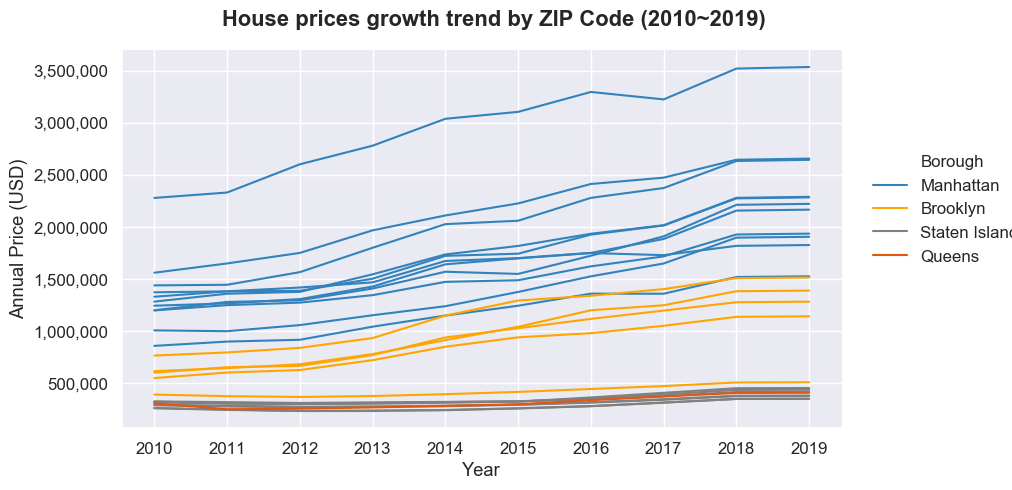

In [84]:
# house price trend (2010~2019)
sns.set_style("darkgrid")
sns.set(font_scale=1.1)

clrs = ["#3182bd", "orange", "gray","#e6550d"]
g = sns.relplot(x="year", y="medp", hue="Borough",
             units="zipcode",estimator=None,height=5, aspect=1.75,
            kind="line", data=joinData1,palette=clrs,legend="full")
leg = g._legend
leg.set_bbox_to_anchor([0.83, 0.7])

# add thousand separator to the y-axis label
# code link: https://stackoverflow.com/questions/58846623/add-thousands-comma-separator-to-seaborn-relplot-in-python
for ax in g.axes.flatten():
    ax.yaxis.set_major_formatter(
        tkr.FuncFormatter(lambda y, p: format(int(y), ',')))

# plot formatting    
leg._loc = 2
g.fig.suptitle("House prices growth trend by ZIP Code (2010~2019)", fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Annual Price (USD)')
plt.subplots_adjust(top=0.90)
;
# plt.savefig('(A) Graphs/house price trend.png')

# Craft maps

In [85]:
# load in base map (zip code level)
# map_zip = gpd.read_file('ZIP_CODE_040114/ZIP_CODE_040114.shp')
map_zip = map_zip.to_crs({"init": "epsg:4326"})

# Net_revenue

''

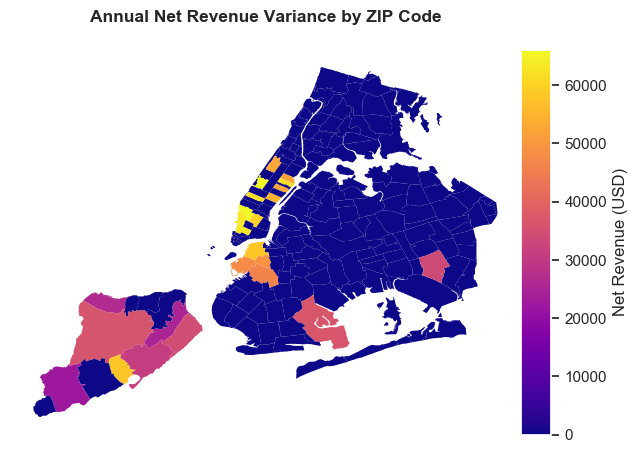

In [86]:
# create a new col 'net_revenue' in map_zip
map_zip['net_revenue'] = 0 # assign 0 to those zip codes that are not in the joinData2 set
idx1=map_zip.columns.get_loc('net_revenue')
idx2=joinData2.columns.get_loc('net_revenue')
for i in range(len(joinData2.zipcode)):
    for j in range(len(map_zip.ZIPCODE)):
        if joinData2.zipcode[i] == int(map_zip.ZIPCODE[j]):
            map_zip.iloc[j, idx1] = joinData2.iloc[i, idx2]
#             print(i, j, joinData2.zipcode[i], map_zip.iloc[j, idx1], joinData2.iloc[i, idx2])

# set font and figure size
sns.set(font_scale=1.0)
fig,ax = plt.subplots(figsize=(7,5))

# set title
plt.title("Annual Net Revenue Variance by ZIP Code",fontsize=12.5,y=1.05,fontweight='bold')

# adjust legend 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%")

# craft map
p_ = map_zip.plot(ax=ax,column='net_revenue', cmap='plasma',legend=True,cax=cax,edgecolor='None',
                 legend_kwds={'label': "Net Revenue (USD)"})

ax.axis('off') # remove axes edges
;
# plt.savefig('(A) Graphs/net revenue.png')

# Investment (cost)

''

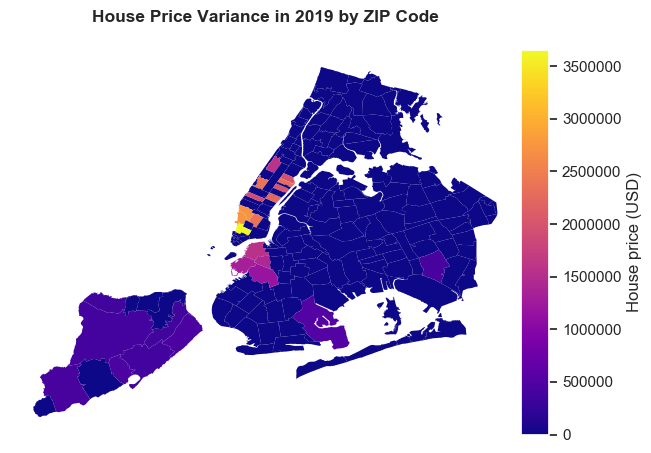

In [87]:
# create a new col 'investment' in map_zip
map_zip['investment'] = 0
idx1=map_zip.columns.get_loc('investment')
idx2=joinData2.columns.get_loc('investment')
for i in range(len(joinData2.zipcode)):
    for j in range(len(map_zip.ZIPCODE)):
        if joinData2.zipcode[i] == int(map_zip.ZIPCODE[j]):
            map_zip.iloc[j, idx1] = joinData2.iloc[i, idx2]
#             print(i, j, joinData2.zipcode[i], map_zip.iloc[j, idx1], joinData2.iloc[i, idx2])

# set font and figure size
sns.set(font_scale=1.0)
fig,ax = plt.subplots(figsize=(7,5))

# set title
plt.title("House Price Variance in 2019 by ZIP Code",fontsize=12.5,y=1.05,fontweight='bold')

# adjust legend 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5.5%")

# craft map
p_ = map_zip.plot(ax=ax,column='investment', cmap='plasma',legend=True,cax=cax,edgecolor='None',
                 legend_kwds={'label': "House price (USD)"})

ax.axis('off') # remove axes edges
;
# plt.savefig('(A) Graphs/investment.png')

# Profit

''

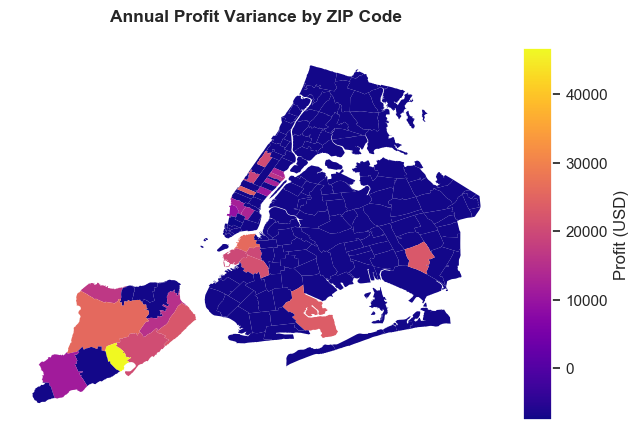

In [88]:
# create a new col 'profit' in map_zip
map_zip['profit'] = -7000
idx1=map_zip.columns.get_loc('profit')
idx2=joinData2.columns.get_loc('profit')
for i in range(len(joinData2.zipcode)):
    for j in range(len(map_zip.ZIPCODE)):
        if joinData2.zipcode[i] == int(map_zip.ZIPCODE[j]):
            map_zip.iloc[j, idx1] = joinData2.iloc[i, idx2]
#             print(i, j, joinData2.zipcode[i], map_zip.iloc[j, idx1], joinData2.iloc[i, idx2])

# set font and figure size
sns.set(font_scale=1.0)
fig,ax = plt.subplots(figsize=(7,5))

# set title
plt.title("Annual Profit Variance by ZIP Code",fontsize=12.5,y=1.05,fontweight='bold')

# adjust legend 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.2)

# craft map
p_ = map_zip.plot(ax=ax,column='profit', cmap='plasma',legend=True,cax=cax,edgecolor='None',
                 legend_kwds={'label': "Profit (USD)"})

ax.axis('off') # remove axes edges
;
# plt.savefig('(A) Graphs/profit.png')

# Annual expenses variance map by zip code

In [89]:
# create a new col 'expenses' in map_zip
map_zip['expenses'] = -2  # assign -2 to those zipcodes that are not in the joinData2 set
idx1=map_zip.columns.get_loc('expenses')
idx2=joinData2.columns.get_loc('expenses')
for i in range(len(joinData2.zipcode)):
    for j in range(len(map_zip.ZIPCODE)):
        if joinData2.zipcode[i] == int(map_zip.ZIPCODE[j]):
            map_zip.iloc[j, idx1] = joinData2.iloc[i, idx2]
#             print(i, j, joinData2.zipcode[i], map_zip.iloc[j, idx1], joinData2.iloc[i, idx2])

''

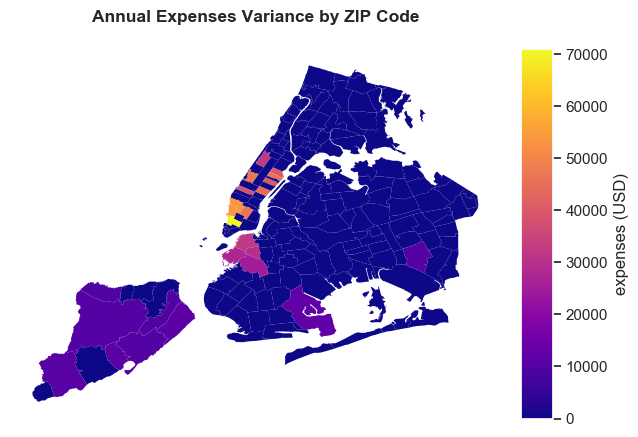

In [90]:
sns.set(font_scale=1.0)
fig,ax = plt.subplots(figsize=(7,5))

plt.title("Annual Expenses Variance by ZIP Code",fontsize=12.5,y=1.05,fontweight='bold')
# adjust legend size and position
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6.5%",pad=0.2)
# cax = divider.new_horizontal(size="5%",pad=0.5)
# colorbar_axes = divider.append_axes('top', size="5%", pad=0.25, add_to_figure=True)

# legend = plt.legend()
# legend.get_frame().set_facecolor('none')
p_ = map_zip.plot(ax=ax,column='expenses', cmap='plasma',legend=True,cax=cax,edgecolor='None',
                 legend_kwds={'label': "expenses (USD)"})
ax.axis('off')
;
# plt.savefig('(A) Graphs/expenses.png')

# ROI bar plot

''

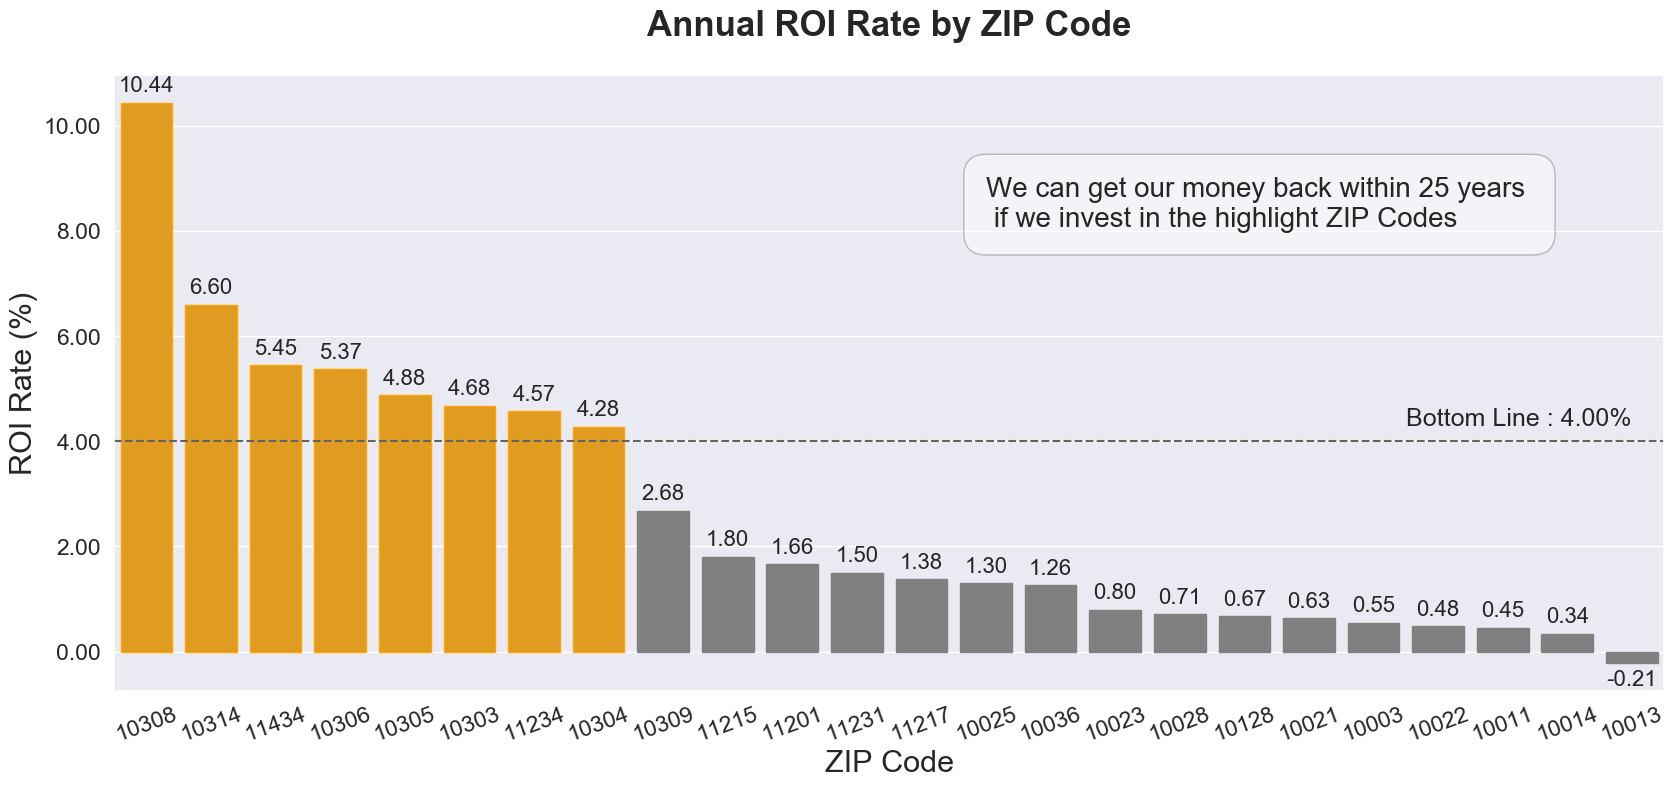

In [91]:
sns.set_style("darkgrid")
sns.set(font_scale=1.5)
# set the size of the figure
fig, ax = plt.subplots(figsize=(20,8)) 
ROIPlot = joinData2.sort_values('ROI',ascending=False)
# self-define palette
clrs = ['orange' if (y < 8) else 'gray' for y in np.arange(0, len(ROIPlot.ROI)) ]
# craft the plot
sns.barplot(y='ROI', x=np.arange(0,len(ROIPlot.ROI)), data=ROIPlot,palette=clrs,
            edgecolor=clrs,ax=ax)
ax.set_xticklabels(ROIPlot.zipcode)
plt.title("Annual ROI Rate by ZIP Code",fontsize=25,y=1.05,fontweight='bold')

plt.xticks(rotation=20) 
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel('ZIP Code',fontsize=22)
ax.set_ylabel('ROI Rate (%)',fontsize=22)
plt.savefig("ROI.png")
ax.axhline(4.00, ls='--',color='#636363') # reference link:https://baike.baidu.com/item/%E7%A7%9F%E9%87%91%E5%9B%9E%E6%8A%A5%E7%8E%87
bbox_props = dict(boxstyle="round,pad=0.8,rounding_size=0.8", fc="w", ec="0.5", alpha=0.5)
ax.text(13, 8.5, "We can get our money back within 25 years \n if we invest in the highlight ZIP Codes", ha="left", va="center", size=20,
        bbox=bbox_props,clip_on=True)
ax.text(19.5,4.3, "Bottom Line : 4.00%")

# add text label for each bin
# the add_value_labels() function is from:
# https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart

def add_value_labels(ax, spacing=5):
#     """Add labels to the end of each bar in a bar chart.

#     Arguments:
#         ax (matplotlib.axes.Axes): The matplotlib object containing the axes
#             of the plot to annotate.
#         spacing (int): The distance between the labels and the bars.
#     """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with two decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va,fontsize=16)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)
;
# plt.savefig('(A) Graphs/ROI barplot.png')

# Selected zipcodes on map

In [92]:
map_zip['hlt'] = 0 # creating new column
idx1=map_zip.columns.get_loc('hlt')
idx2=joinData2.columns.get_loc('ROI')
zip_list = [10308,10314,11434,10306,10305,10303,11234,10304]
ROI_list = []
for i in range(len(zip_list)):
    for j in range(len(joinData2.zipcode)):
        if zip_list[i] == joinData2.zipcode[j]:
            ROI_list.append(joinData2.iloc[j, idx2])
# print(ROI_list)



for i in range(len(zip_list)):
    for j in range(len(map_zip.ZIPCODE)):
        if zip_list[i] == int(map_zip.ZIPCODE[j]):
            map_zip.iloc[j, idx1] = ROI_list[i]

''

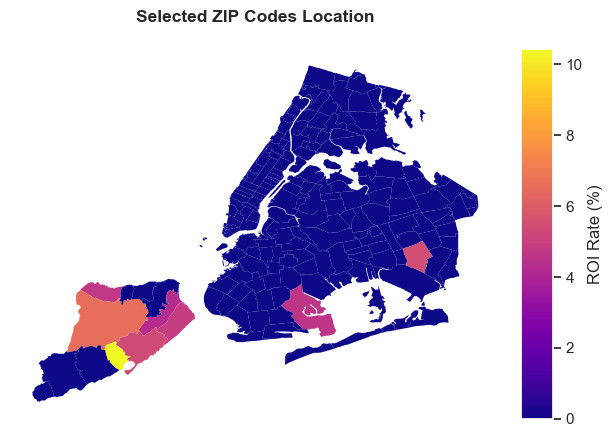

In [93]:
sns.set(font_scale=1.0)
fig,ax = plt.subplots(figsize=(7,5))

plt.title("Selected ZIP Codes Location",fontsize=12.5,y=1.05,fontweight='bold')
# adjust legend size and position
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6.5%",pad=0.2)
# cax = divider.new_horizontal(size="5%",pad=0.5)
# colorbar_axes = divider.append_axes('top', size="5%", pad=0.25, add_to_figure=True)

# legend = plt.legend()
# legend.get_frame().set_facecolor('none')
p_ = map_zip.plot(ax=ax,column='hlt', cmap='plasma',legend=True,cax=cax,edgecolor='None',
                 legend_kwds={'label': "ROI Rate (%)"})
ax.axis('off')
;
# plt.savefig('(A) Graphs/Hlt zip codes_pl.png')